/tmp/ipykernel_2720661/3793265853.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, dtype=torch.float32).unsqueeze(0)


Epoch 1/50, Train Loss: 0.0841, Val Loss: 0.0199
Epoch 2/50, Train Loss: 0.0165, Val Loss: 0.0130
Epoch 3/50, Train Loss: 0.0123, Val Loss: 0.0115
Epoch 4/50, Train Loss: 0.0115, Val Loss: 0.0107
Epoch 5/50, Train Loss: 0.0107, Val Loss: 0.0104
Epoch 6/50, Train Loss: 0.0101, Val Loss: 0.0097
Epoch 7/50, Train Loss: 0.0101, Val Loss: 0.0095
Epoch 8/50, Train Loss: 0.0093, Val Loss: 0.0111
Epoch 9/50, Train Loss: 0.0103, Val Loss: 0.0091
Epoch 10/50, Train Loss: 0.0089, Val Loss: 0.0091
Epoch 11/50, Train Loss: 0.0087, Val Loss: 0.0085
Epoch 12/50, Train Loss: 0.0086, Val Loss: 0.0085
Epoch 13/50, Train Loss: 0.0087, Val Loss: 0.0086
Epoch 14/50, Train Loss: 0.0084, Val Loss: 0.0085
Epoch 15/50, Train Loss: 0.0084, Val Loss: 0.0082
Epoch 16/50, Train Loss: 0.0084, Val Loss: 0.0083
Epoch 17/50, Train Loss: 0.0082, Val Loss: 0.0082
Epoch 18/50, Train Loss: 0.0082, Val Loss: 0.0085
Epoch 19/50, Train Loss: 0.0082, Val Loss: 0.0081
Epoch 20/50, Train Loss: 0.0081, Val Loss: 0.0081
Epoch 21/

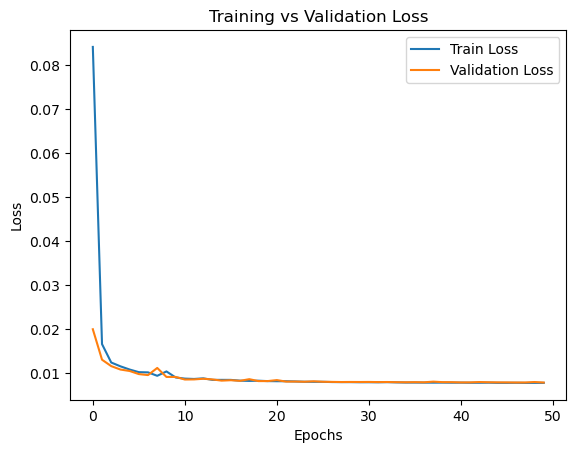

In [58]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, random_split
import tifffile as tiff
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

# Custom Dataset Loader for Unlabeled TIFF Images
class UnlabeledTIFFDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = [os.path.join(root_dir, fname) for fname in os.listdir(root_dir) if fname.lower().endswith(('tif', 'tiff'))]
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        try:
            image = tiff.imread(img_path).astype(np.float32)            
            if image.ndim == 3:
                image = image[0]
        except Exception as e:
            print(f"Warning: Skipping unreadable image {img_path} - {e}")
            return self.__getitem__((idx + 1) % len(self.image_paths))
        
        if self.transform:
            image = self.transform(image)
        image = torch.tensor(image, dtype=torch.float32).unsqueeze(0)
        image = image.squeeze(1)
        return image, 0

# Step 1: Define the Autoencoder (VAE)
class VAE(nn.Module):
    def __init__(self, latent_dim=8):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten()
        )
        self.fc_mu = nn.Linear(128 * 8 * 8, latent_dim)
        self.fc_logvar = nn.Linear(128 * 8 * 8, latent_dim)
        self.fc_decode = nn.Linear(latent_dim, 128 * 8 * 8)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def forward(self, x):
        x = self.encoder(x)
        mu, logvar = self.fc_mu(x), self.fc_logvar(x)
        z = self.reparameterize(mu, logvar)
        x = self.fc_decode(z).view(-1, 128, 8, 8)
        return self.decoder(x), mu, logvar

# Step 2: Train Autoencoder and Extract Latent Representations
def train_vae(model, train_loader, val_loader, epochs=50, lr=1e-3):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()
    train_losses, val_losses = [], []
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for x, _ in train_loader:
            x = x.to(device)
            recon, mu, logvar = model(x)
            loss = loss_fn(recon, x) + 0.1 * (mu.pow(2).mean() + logvar.exp().mean())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for x, _ in val_loader:
                x = x.to(device)
                recon, mu, logvar = model(x)
                loss = loss_fn(recon, x) + 0.1 * (mu.pow(2).mean() + logvar.exp().mean())
                val_loss += loss.item()
        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
    
    # Plot training and validation loss
    plt.plot(range(epochs), train_losses, label='Train Loss')
    plt.plot(range(epochs), val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training vs Validation Loss')
    plt.show()
    
    return model


# Load Data
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data_dir = '/mnt/d/lding/FA/analysis_results/encoder/partitioned_data_rand_flow/annabel_0226_patchsize_64'
transform = transforms.Compose([transforms.ToTensor()])
dataset = UnlabeledTIFFDataset(root_dir=data_dir, transform=transform)

# Split dataset into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)

# Train VAE
vae = VAE().to(device)
vae = train_vae(vae, train_loader, val_loader)


In [50]:

# Step 3: Cluster in 32D Latent Space
def cluster_latents(model, dataloader, num_clusters=4):
    model.eval()
    latents = []
    images = []
    with torch.no_grad():
        for x, _ in dataloader:
            x = x.to(device)
            _, mu, _ = model(x)
            latents.append(mu.cpu().numpy())
            images.append(x.cpu())
    latents = np.concatenate(latents, axis=0)
    images = torch.cat(images, dim=0)
    
    # Apply K-Means clustering in 32D latent space
    kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(latents)
    labels = kmeans.labels_
    return latents, labels, images

# Step 4: Visualize Clusters with t-SNE and Reconstructed Images
def visualize_clusters(latents, labels, images, model):
    tsne = TSNE(n_components=2, perplexity=30, random_state=42)
    latents_2d = tsne.fit_transform(latents)
    
    plt.figure(figsize=(8, 6))
    plt.scatter(latents_2d[:, 0], latents_2d[:, 1], c=labels, cmap='tab10', alpha=0.7,s=0.5)    
    plt.xlabel("t-SNE Dimension 1")
    plt.ylabel("t-SNE Dimension 2")
    plt.title("2D Visualization of Latent Space using t-SNE")
    plt.show()
    
    # Select one image per cluster
    selected_images = []
    selected_labels = set()
    for i, label in enumerate(labels):
        if label not in selected_labels:
            selected_labels.add(label)
            selected_images.append(images[i])
        if len(selected_labels) == 4:
            break
    
    selected_images = torch.stack(selected_images).to(device)
    reconstructed, _, _ = model(selected_images)
    
    # Display original and reconstructed images
    fig, axes = plt.subplots(2, len(selected_images), figsize=(15, 5))
    for i in range(len(selected_images)):
        axes[0, i].imshow(selected_images[i].squeeze().cpu(), cmap='gray', vmax=1.0,vmin=0)
        axes[1, i].imshow(reconstructed[i].squeeze().cpu().detach(), cmap='gray', vmax=1.0,vmin=0)
        axes[0, i].axis('off')
        axes[1, i].axis('off')
    plt.show()

In [56]:
def cluster_and_display_images(vae, dataloader, num_clusters=5):
    vae.eval()
    latents, images = [], []
    with torch.no_grad():
        for x, _ in dataloader:
            x = x.to(device)
            _, mu, _ = vae(x)
            latents.append(mu.cpu().numpy())
            images.append(x.cpu())
    latents = np.concatenate(latents, axis=0)
    images = torch.cat(images, dim=0)
    
    # Apply K-Means clustering
    kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(latents)
    labels = kmeans.labels_
    
    # Select 10 images per cluster for visualization
    num_images_per_cluster = 6
    selected_images, selected_reconstructions = [], []
    for cluster_id in range(num_clusters):
        indices = np.where(labels == cluster_id)[0][:num_images_per_cluster]
        selected_images.append(images[indices])
    selected_images = torch.cat(selected_images).to(device)
    
    # Generate reconstructions
    with torch.no_grad():
        reconstructions, _, _ = vae(selected_images)
    
    # Display images in 8x10 grid (10 images per cluster, original vs reconstructed)
    fig, axes = plt.subplots(num_clusters, num_images_per_cluster, figsize=(15, num_clusters * 2))
    for i in range(num_clusters):
        for j in range(num_images_per_cluster):
            axes[i, j].imshow(selected_images[i * num_images_per_cluster + j].squeeze().cpu(), cmap='gray')
            axes[i, j].axis('off')
            axes[i, j].set_title(f"C{i+1}") if j == 0 else None
    
    plt.show()
    
    fig, axes = plt.subplots(num_clusters, num_images_per_cluster, figsize=(15, num_clusters * 2))
    for i in range(num_clusters):
        for j in range(num_images_per_cluster):
            axes[i, j].imshow(reconstructions[i * num_images_per_cluster + j].squeeze().cpu(), cmap='gray')
            axes[i, j].axis('off')
    
    plt.show()

/tmp/ipykernel_2720661/2033546821.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, dtype=torch.float32).unsqueeze(0)  # Ensure correct dtype and shape


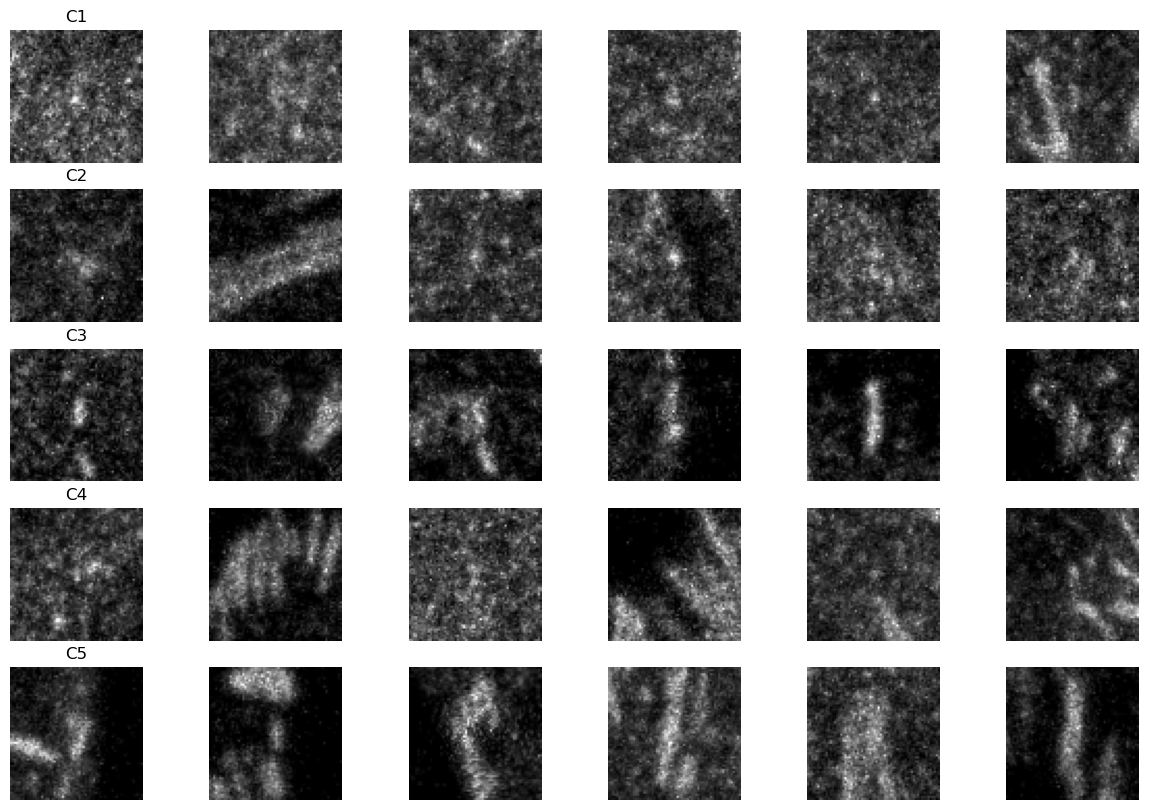

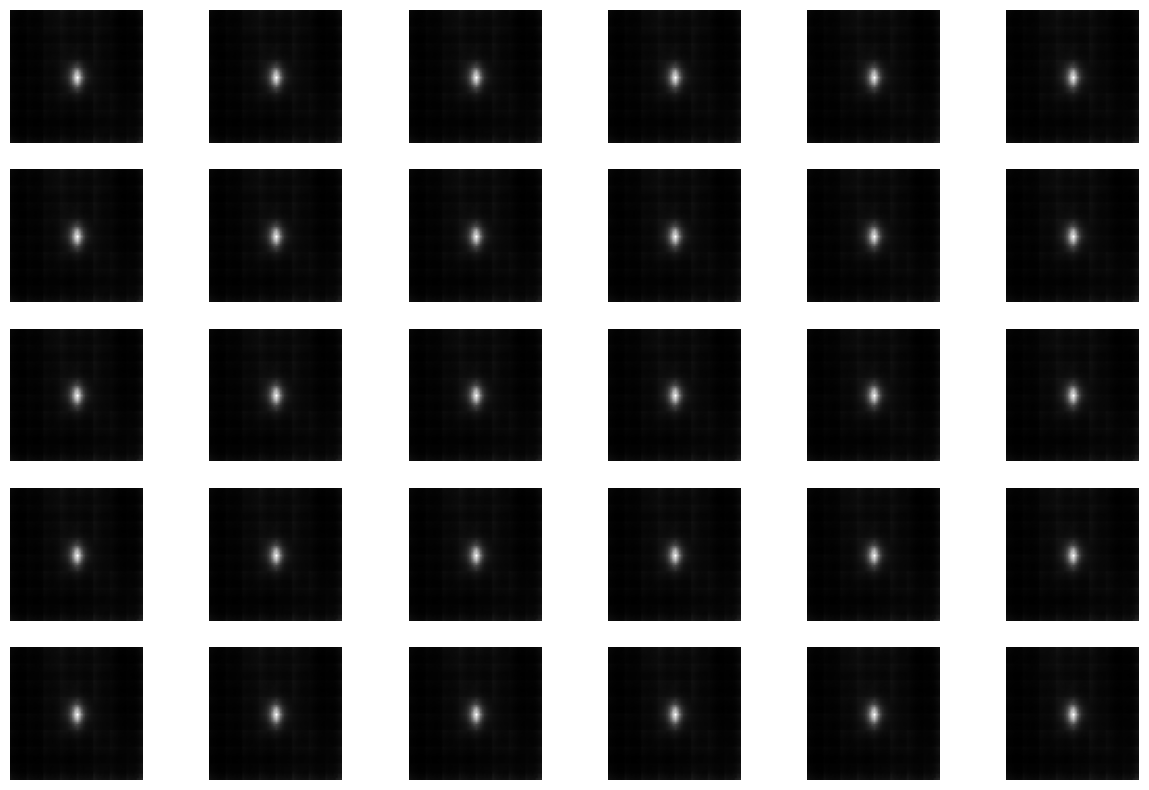

In [57]:
# Perform clustering and display images
cluster_and_display_images(vae, dataloader)


In [42]:

latents, labels, images = cluster_latents(vae, train_loader)



/tmp/ipykernel_2720661/3793265853.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, dtype=torch.float32).unsqueeze(0)


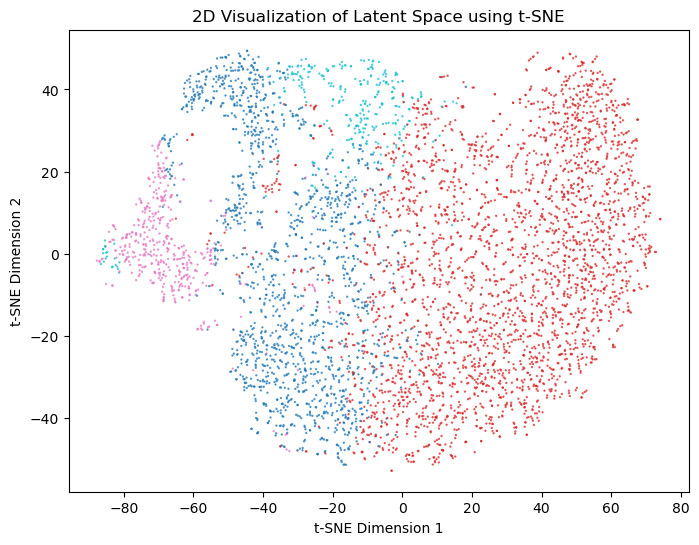

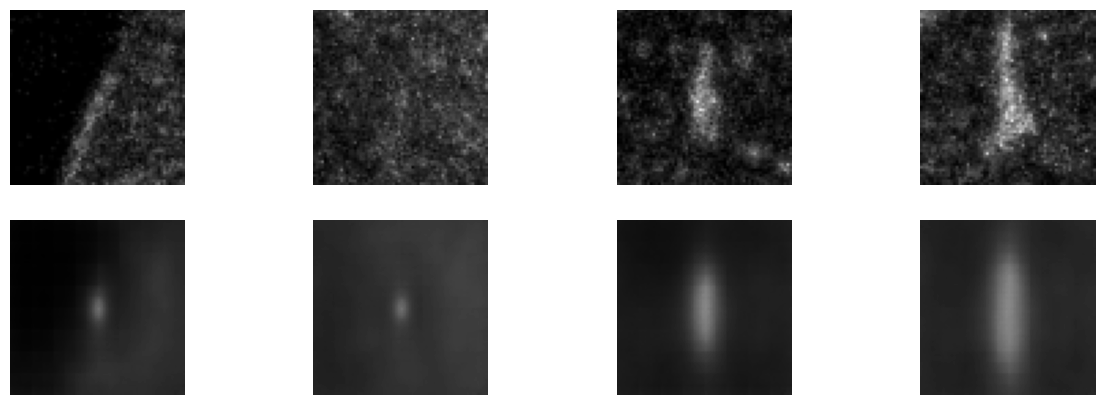

Training, clustering, and visualization completed!


In [51]:
# Visualize clusters and reconstructed images
visualize_clusters(latents, labels, images, vae)


print("Training, clustering, and visualization completed!")

In [47]:
latents.shape

(5464, 8)

In [44]:
def latent_traversal(model, sample_image, feature_idx, step_size=0.1):
    model.eval()
    sample_image = sample_image.unsqueeze(0).to(device)
    
    # Encode image into latent space
    _, mu, _ = model(sample_image)
    latent_vector = mu.clone().detach()
    
    fig, axes = plt.subplots(1, 5, figsize=(15, 3))
    for i, alpha in enumerate(np.linspace(-step_size, step_size, 5)):
        new_latent = latent_vector.clone()
        new_latent[:, feature_idx] += alpha  # Modify one feature
        
        # Decode and visualize
        recon = model.decoder(model.fc_decode(new_latent).view(-1, 128, 8, 8)).cpu().detach()
        axes[i].imshow(recon.squeeze().numpy(), cmap="gray")
        axes[i].set_title(f"Feature {feature_idx}, {alpha:.1f}")
        axes[i].axis("off")
    
    plt.show()

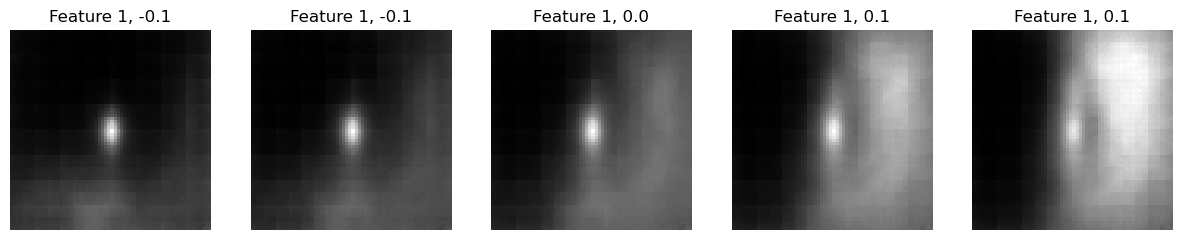

In [45]:
latent_traversal(vae, images[0], feature_idx=1)


In [46]:
images[0,0,:,:].shape

torch.Size([64, 64])